**MACS205a - Differential equations**

*Group members:*
- *ABUBAKER Rita*
- *BERRONDO Alice*
- *LY Timothée*
- *PERSONNAZ Louis*
- *TOURTOIS Eliott*
- *WINTER Alexis*

# Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp

# Code

In [30]:
# Initial conditions
Atmosphere_Initial          = 750
CarbonateRock_Initial       = 100000000
DeepOcean_Initial           = 38000
FossilFuel_Initial          = 7500
Plant_Initial               = 560
Soil_Initial                = 1500
SurfaceOcean_Initial        = 890
VegLandArea_percent_Initial = 100

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Fossil fuel
FossFuelData = np.array([[50.0, 0.00],
                         [75.0, 0.30],
                         [100.0, 0.60],
                         [125.0, 1.35],
                         [150.0, 2.85],
                         [175.0, 4.95],
                         [200.0, 7.20],
                         [225.0, 10.05],
                         [250.0, 14.85],
                         [275.0, 20.70],
                         [300.0, 30.00]])

In [31]:
# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return (FossFuelData[i-1,1]
             + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1]))

def derivative(x, t):
    Atmosphere          = x[0]
    CarbonateRock       = x[1]
    DeepOcean           = x[2]
    FossilFuelCarbon    = x[3]
    Plants              = x[4]
    Soils               = x[5]
    SurfaceOcean        = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial)) + (Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp
                    + SoilResp
                    + Volcanoes
                    + FossilFuelsCombustion_
                    - Photosynthesis
                    - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt = Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
    ])

    return derivative

In [112]:
class Model():
    """Represents a model for the carbon cycle"""
    
    def __init__(self, initial_conditions):
        self.initial_conditions = initial_conditions
        self.attr = {0: "Atmosphere",
                     1: "CarbonateRock",
                     2: "DeepOcean",
                     3: "FossilFuel",
                     4: "Plant",
                     5: "Soil",
                     6: "SurfaceOcean",
                     7: "VegLandArea_percent"}
        self.params  = self.attr.values()
        self.message = None
        self.success = None
        self.t       = None
        self.y       = None
        
    def predict(self, method_, startYear, endYear, *args, **kwargs):
        if method_ == "solve_ivp":
            t_span = (startYear, endYear)
            derivative_ = lambda t, y: derivative(y, t) # invert the order of the arguments for solve_ivp
            res = solve_ivp(fun=derivative_, t_span=t_span, y0=self.initial_conditions, *args, **kwargs)
            self.message, self.success, self.t, self.y = res.message, res.success, res.t, res.y
        if method_ == "RK4":
            self.message, self.success = None, None
            self.t = np.linspace(startYear, endYear, num=kwargs["num"])
            self.y = rungeKutta4(derivative, self.initial_conditions, self.t).T
            
    def plot_evolution(self, params, figsize=(12, 6)):
        fig = plt.figure(figsize=figsize)
        for idx in range(self.y.shape[0]):
            if self.attr[idx] in params:
                plt.plot(self.t, self.y[idx], label=self.attr[idx])
                plt.xlabel("Time (years)")
        plt.legend()
        plt.show()

In [113]:
initial_conditions = np.array([Atmosphere_Initial,
                               CarbonateRock_Initial,
                               DeepOcean_Initial,
                               FossilFuel_Initial,
                               Plant_Initial,
                               Soil_Initial,
                               SurfaceOcean_Initial,
                               VegLandArea_percent_Initial])
model = Model(initial_conditions)

In [117]:
def rungeKutta4(f, y0, t):
    """
    params:
    f: 2-params derivative function
    y0: initial condition
    t: array of years
    """
    n = len(t) 
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n-1):
        h = t[i+1] - t[i]
        
        p1 = f(y[i], t[i])
        t2 = t[i] + 1/2 * h
        y2 = y[i] + 1/2 * h * p1
        
        p2 = f(y2, t2)
        t3 = t2
        y3 = y[i] + 1/2 * h * p2
        
        p3 = f(y3, t3)
        t4 = t[i] + h 
        y4 = y[i] + h * p3
        
        p4 = f(y4, t4)
        
        y[i+1] = y[i] + h * (p1/6 + 2*p2/6 + 2*p3/6 + p4/6)
    
    return y

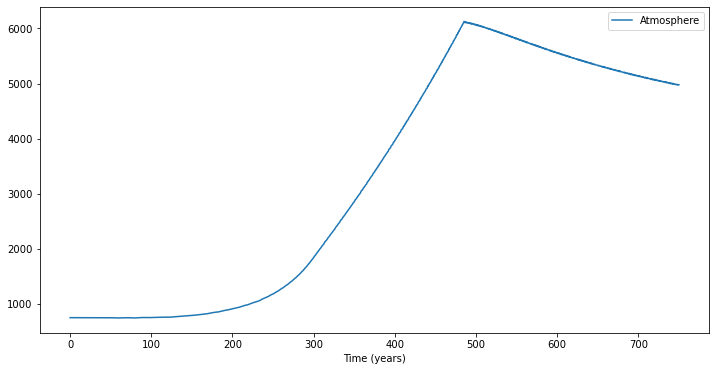

In [118]:
model.predict("solve_ivp", 0, 750, method="RK45")
model.plot_evolution(["Atmosphere"])

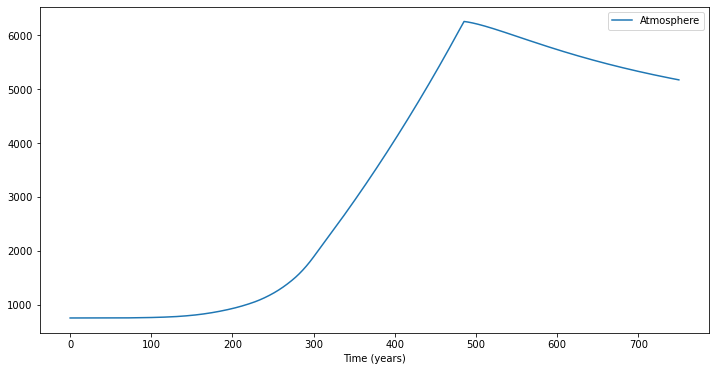

In [124]:
model.predict("RK4", 0, 750, num=5000)
model.plot_evolution(["Atmosphere"])